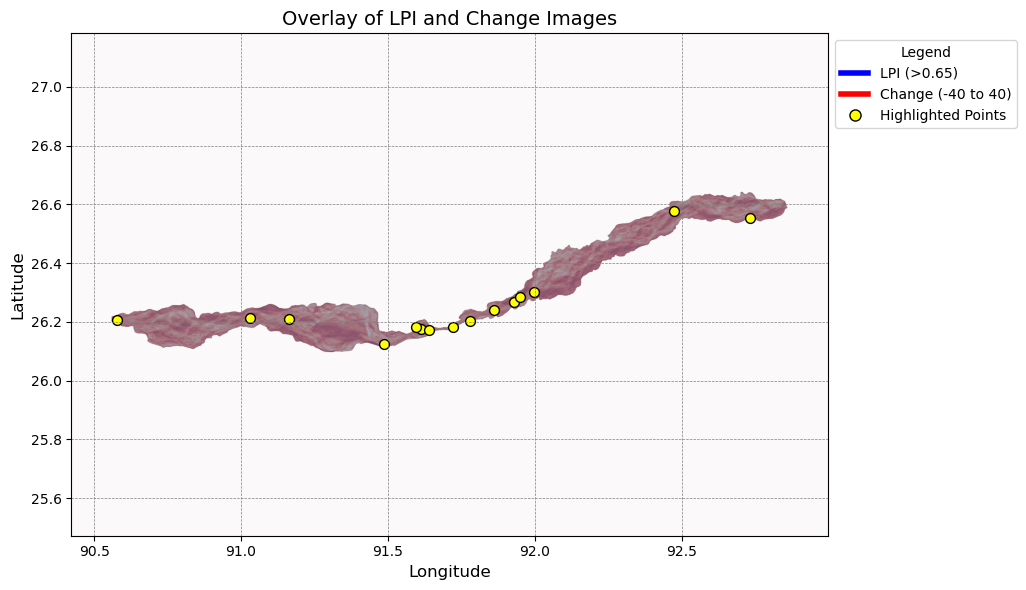

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# File paths
lpi_file = r"H:\Major_Project\Work\lpicodes\Brahmaputra_Output\W1_Channel.tif"
change_file = r"H:\Major_Project\Work\JRC_Change\Brhamaputra_Change_Channel.tif"
output_file = r"H:\Major_Project\Work\Overlay_Brahmaputra_New_Channel_1_trial.png"
csv_output_file = r"H:\Major_Project\Work\Highlighted_Points_Brahmaputra_New_Channel_1_trial.csv"

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Initialize geocoder
geolocator = Nominatim(user_agent="geoapi", timeout=10)

def get_place_name(lat, lon):
    """Get place name based on coordinates."""
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location:
            address = location.raw.get('address', {})
            return address.get('village') or address.get('town') or address.get('city') or address.get('county') or "Unknown"
        return "Unknown"
    except GeocoderTimedOut:
        return "Unknown"

# Open the raster files
with rasterio.open(lpi_file) as lpi_src, rasterio.open(change_file) as change_src:
    lpi = lpi_src.read(1)  # Read LPI band
    change = change_src.read(1)  # Read Change band

    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot LPI Layer (Blue)
    lpi_plot = ax.imshow(lpi, cmap="Blues", extent=[
        lpi_src.bounds.left, lpi_src.bounds.right, lpi_src.bounds.bottom, lpi_src.bounds.top
    ], alpha=0.6)

    
    # Plot Change Layer (Red)
    change_plot = ax.imshow(change, cmap="Reds", extent=[
        change_src.bounds.left, change_src.bounds.right, change_src.bounds.bottom, change_src.bounds.top
    ], alpha=0.4)

    # Find points to highlight (LPI > 0.65 & -40 <= Change <= 40)
    highlight_mask = (lpi > 0.65) & ((change >= -40) & (change <= 40))
    y_indices, x_indices = np.where(highlight_mask)

    # Select 10-15 random points for labeling
    sample_size = min(15, len(y_indices))
    highlighted_data = []
    
    if sample_size > 0:
        sampled_indices = np.random.choice(len(y_indices), sample_size, replace=False)
        y_indices, x_indices = y_indices[sampled_indices], x_indices[sampled_indices]

        for y, x in zip(y_indices, x_indices):
            lon, lat = lpi_src.xy(y, x)
            highlighted_data.append({
                "Place Name": get_place_name(lat, lon),
                "Latitude": round(lat, 4),
                "Longitude": round(lon, 4),
                "LPI Value": round(lpi[y, x], 4),
                "Change Value": round(change[y, x], 4)
            })
            ax.scatter(lon, lat, color='yellow', edgecolor='black', s=50)

    # Save to CSV
    if highlighted_data:
        pd.DataFrame(highlighted_data).to_csv(csv_output_file, index=False)

    # Customize plot
    ax.set_title("Overlay of LPI and Change Images", fontsize=14)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.grid(color="gray", linestyle="--", linewidth=0.5)

    # Custom Legend
    legend_labels = [
        plt.Line2D([0], [0], color="blue", lw=4, label="LPI (>0.65)"),
        plt.Line2D([0], [0], color="red", lw=4, label="Change (-40 to 40)"),
        plt.Line2D([0], [0], marker="o", color="yellow", label="Highlighted Points", markersize=8, markeredgecolor="black", linestyle="")
    ]
    ax.legend(handles=legend_labels, title="Legend", loc="upper left", bbox_to_anchor=(1.00, 1), fontsize=10, frameon=True)

    # Save & Show
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
